In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
    cdict,
)
from deq2ff.plotting.dashboard import get_runs_from_wandb, filter_best_runs, mark_sota, add_best_run, preprocess_df, print_table_acc_time

nans = ["NaN", pd.NA, None, float("inf"), np.nan]



In [2]:


# set_seaborn_style()

# MD17, MD22

In [3]:
# Config
project = projectmd

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val, 
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

In [4]:
df = get_runs_from_wandb(
    project=project, download_data=True,
    filters = {
        # https://www.mongodb.com/docs/manual/reference/operator/query-comparison/
        "$or": [{"state": "finished"}, {"state": "crashed"}],
        "tags": {"$nin": ["eval", "inf"]}
    }
)
df = preprocess_df(df=df, project=project, error_metric=error_metric)

Found 406 runs:
Saved dataframe.
before filter: 406
after filter: 401


In [5]:
# print([k for k in df.keys() if k.startswith("summary.test")])
# print([k for k in df.keys() if k.startswith("summary.val")])
# print([k for k in df.keys() if k.startswith("config.deq_kwargs")])
# df[["run_name", "config.target", error_metric]]

In [6]:
if project == projectmd:
    df_best_runs = filter_best_runs(
        df=df, error_metric=error_metric,
        # "config.norm_by_natoms" can be False or NaN, but not True
        # config.dname can be md17 or md22 but not ccsd
        criteria={
            "config.seed": 1,
            "config.clip_grad_norm": 1000,
            "config.model.attn_alpha_channels": 16,
            "config.lr": 5e-4,
        },
        anti_criteria={
            "config.decay_rate": 1,
            "config.dname": "ccsd",
            "config.norm_by_natoms": True,
            "config.model.forces_via_grad": True,
        }
    )

elif project == projectoc:
    df_best_runs = filter_best_runs(
        df=df, error_metric=error_metric,
        criteria={
            "config.model.attn_alpha_channels": 64, # reg
        },
        anti_criteria={
            "config.decay_rate": 1, # constlr
        }
    )

In [7]:
if project == projectoc:
    targets = ["200k e3", "2M e1"]
    df_best_runs = df_best_runs[df_best_runs["config.target"].isin(targets)]

In [8]:
df_best_runs = mark_sota(df_best_runs, comparison="pairwise", error_metric=error_metric)

# defragment
df_best_runs = df_best_runs.copy()

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:345: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[sotaname] = False


In [9]:
# df_best_runs[df_best_runs["sota"] == True][["run_name", "config.target", error_metric, "sota"]]

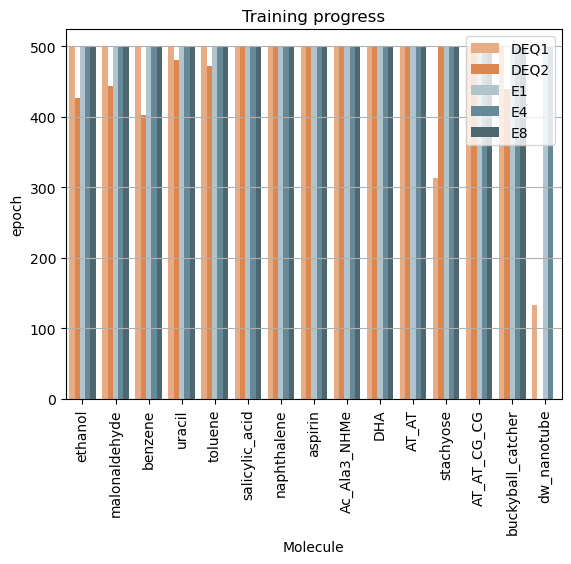

In [10]:
# plot how far training has progressed (steps / epochs)
if project == projectmd:
    y = "summary.epoch"
elif project == projectoc:
    y = "summary.train/step"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
# pallete: dictionary mapping hue levels to matplotlib colors
sns.barplot(
    x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict, 
    # gap=0.1
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Training progress")

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
plt.show()

In [11]:
# remove dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

In [12]:
# runs I need to reinitialize
if project == projectmd:
    prefix = "launchrun"
    
    # runs with DEQ2
    df_deq2 = df_best_runs[df_best_runs["Model"] == "DEQ2"]
    # print commands used to launch these runs
    for i, row in df_deq2.iterrows():
        # print(f"epoch {row['summary.epoch']} {rname['config.epochs']}")
        if row['summary.epoch'] >= row['config.epochs'] - 1:
            continue
        overrides = row['config.override_dirname'].split(',')
        overrides = [o for o in overrides if "wandb_tags" not in o]
        overrides = " ".join([f"{o}" for o in overrides])
        print(f"{prefix} {overrides}")

launchrun +cfg=ap +use=deq model.num_layers=2 target=ethanol
launchrun +cfg=bp +use=deq model.num_layers=2 target=malonaldehyde
launchrun +cfg=ap +use=deq model.num_layers=2 target=benzene
launchrun +cfg=bp +use=deq model.num_layers=2 target=uracil
launchrun +cfg=bp +use=deq model.num_layers=2 target=toluene
launchrun +cfg=apt +use=deq dname=md22 model.num_layers=2 target=buckyball_catcher


In [13]:
# speedtest: give me the commands I need to run
if project == projectmd:
    prefix = "launchrun"
    tag = "['speedmd_v1']"
elif project == projectoc:
    prefix = "launchoc"
    tag = "['speedoc_v1']"
    
# df[["config.override_dirname"]]
print(' ')
_num_runs = 0
for i, row in df_best_runs.iterrows():
    overrides = row['config.override_dirname'].split(',')
    overrides = [o for o in overrides if ("wandb_tags" not in o) and ("target" not in o)]
    overrides = " ".join([f"{o}" for o in overrides])
    target = row['config.target']
    print(
        f"{prefix} {overrides} target={target}", 
        f"+inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags={tag}"
    )
    _num_runs += 1
print(' ')
print(f"Total runs: {_num_runs}")

 
launchrun +cfg=bp +use=deq deq_kwargs.n_states=3 target=ethanol +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=ap +use=deq model.num_layers=2 target=ethanol +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=dd model.num_layers=1 target=ethanol +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=dd model.num_layers=4 target=ethanol +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=dd model.num_layers=8 target=ethanol +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=bp +use=deq target=malonaldehyde +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=bp +use=deq model.num_layers=2 target=malonaldehyde +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=dd model.num_layers=1 target=malonaldehyde +inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags=['speedmd_v1']
launchrun +cfg=dd model.num_layers=4 target=malo

In [14]:
print(f"There should be {df_best_runs['config.target'].unique().shape[0]} target * {df_best_runs['Model'].unique().shape[0]} Model runs", df_best_runs["config.target"].unique().shape[0] * df_best_runs["Model"].unique().shape[0])

There should be 14 target * 5 Model runs 70


In [15]:
df_best_runs[["Model", "config.target", error_metric, "sota"]]

,Model,config.target,summary.test_f_mae,sota
116,DEQ1,ethanol,0.223964,False
253,DEQ2,ethanol,0.206842,True
6,E1,ethanol,0.292738,False
7,E4,ethanol,0.222168,True
9,E8,ethanol,0.217541,False
...,...,...,...,...
333,DEQ1,buckyball_catcher,0.139096,False
356,DEQ2,buckyball_catcher,0.153823,False
40,E1,buckyball_catcher,0.148128,False
41,E4,buckyball_catcher,0.093443,True


In [16]:
#  add speed to table
if project == projectmd:
    # time_forward_total_test_fpreuse, time_forward_per_batch_test_fpreuse,
    # time_test_fpreuse, avg_n_fsolver_steps_test_fpreuse 
    time_metric = "summary.time_forward_per_batch_test_fpreuse"

    dfspeed = get_runs_from_wandb(
        project=project, download_data=True, 
        filters = {
            "tags": "speedmd_v1",
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        }, 
        fname="speedmdv1"
    )

    if len(dfspeed) == 0:
        print("No speed data found")
    else:
        dfspeed = preprocess_df(df=dfspeed, project=project, error_metric=time_metric)

        # remove dw_nanotube
        dfspeed = dfspeed[dfspeed["config.dname"] != "dw_nanotube"]

        # add sotatime column
        dfspeed = mark_sota(dfspeed, comparison="pairwise", error_metric=time_metric, sotaname="sotatime")
        ind = "mtarget"

        df_best_runs = df_best_runs.reset_index(drop=True)
        dfspeed = dfspeed.reset_index(drop=True)

        df_best_runs["sotatime"] = np.nan
        dfspeed["sotatime"] = dfspeed["sotatime"].astype(bool)
        df_best_runs["sotatime"] = df_best_runs["sotatime"].astype(bool)

        # set dtype to float
        tmetrics = ["summary.time_forward_total_test_fpreuse", "summary.time_forward_per_batch_test_fpreuse", 
                    "summary.time_test_fpreuse", "summary.avg_n_fsolver_steps_test_fpreuse", "nstep", "NFE", "NFE_time"]
        for _t in tmetrics:
            df_best_runs[_t] = np.nan
            dfspeed[_t] = dfspeed[_t].astype(float)
            df_best_runs[_t] = df_best_runs[_t].astype(float)

        print(f"Before mergin: {df_best_runs.shape}")
        print(f" mergin dfspeed: {dfspeed.shape}")
        # TODO
        # merge by hand
        # df_best_runs[time_metric] = np.nan
        # df_best_runs["sotatime"] = np.nan
        # for i, row in df_best_runs.iterrows():
        #     # dfspeed[dfspeed["mtarget"] == "DEQ1 ethanol"]["summary.time_forward_per_batch_test_fpreuse"]
    
        #     df_best_runs[time_metric] = dfspeed[time_metric].where(dfspeed[ind] == row[ind], df_best_runs[time_metric])
        #     df_best_runs["sotatime"] = dfspeed["sotatime"].where(dfspeed[ind] == row[ind], df_best_runs["sotatime"])
        #     # print("row", row[ind],time_metric, dfspeed[time_metric].where(dfspeed[ind] == row[ind], df_best_runs[time_metric]))
        #     # print("sotatime", dfspeed["sotatime"].where(dfspeed[ind] == row[ind], df_best_runs["sotatime"]))

        # for i, row in df_best_runs.iterrows():
        #     # print df_best_runs ind
        #     print("row", row[ind], df_best_runs[df_best_runs[ind] == row[ind]][time_metric].item(), df_best_runs[df_best_runs[ind] == row[ind]][time_metric].index, "<-", dfspeed[dfspeed[ind] == row[ind]][time_metric].item())

        #     df_best_runs[df_best_runs[ind] == row[ind]][time_metric] = dfspeed[dfspeed[ind] == row[ind]][time_metric]
        #     df_best_runs[df_best_runs[ind] == row[ind]]["sotatime"] = dfspeed[dfspeed[ind] == row[ind]]["sotatime"]


        # print(df_best_runs[ind].unique(), len(df_best_runs[ind].unique()))
        # print(dfspeed[ind].unique(), len(dfspeed[ind].unique()))

        # merge: add time to best_runs
        # df_best_runs = df_best_runs.merge(
        #     dfspeed[[ind, time_metric, "sotatime"]],
        #     on=ind,
        #     how="left",
        # )
        # df_best_runs = df_best_runs.reset_index(drop=True)

        # df_best_runs[time_metric] = df_best_runs[time_metric].map(dfspeed.set_index(ind)[time_metric])

        # Loop over each row in df2
        for index2, row2 in df_best_runs.iterrows():
            found = False
            # Loop over each row in df1
            for index1, row1 in dfspeed.iterrows():
                # If column B matches, copy value from column A in df1 to df2
                if row2[ind] == row1[ind]:
                    df_best_runs.at[index2, "sotatime"] = row1["sotatime"]
                    df_best_runs.at[index2, time_metric] = row1[time_metric]
                    for _t in tmetrics:
                        df_best_runs.at[index2, _t] = row1[_t]
                    found = True
                    break
            if not found:
                df_best_runs.at[index2, time_metric] = np.nan
                print(f"Could not find {row2[ind]} in dfspeed")

        print(f"After merging: {df_best_runs.shape}")

Found 71 runs:
Saved dataframe.
before filter: 71
after filter: 71
Models: ['DEQ1' 'E1' 'E8' 'E4' 'DEQ2']
Before mergin: (70, 687)
 mergin dfspeed: (71, 325)
After merging: (70, 687)


In [17]:
df_best_runs[[error_metric, time_metric, "sotatime"]]

,summary.test_f_mae,summary.time_forward_per_batch_test_fpreuse,sotatime
0,0.223964,0.162651,False
1,0.206842,0.175741,False
2,0.292738,0.020364,False
3,0.222168,0.043642,True
4,0.217541,0.074406,True
...,...,...,...
65,0.139096,0.231003,False
66,0.153823,0.285609,False
67,0.148128,0.021836,False
68,0.093443,0.047155,True


In [18]:
df_best_runs.shape

(70, 687)

In [19]:
# dfspeed[dfspeed[time_metric].isna()][["run_name", ind, error_metric, time_metric, "sotatime"]]
# dfspeed[["run_name", ind, error_metric, time_metric, "sotatime"]]

In [20]:
dfspeed[dfspeed["mtarget"] == "DEQ1 ethanol"]["summary.time_forward_per_batch_test_fpreuse"]

0    0.162651
Name: summary.time_forward_per_batch_test_fpreuse, dtype: float64

In [21]:
# print rows where time_metric is nan
df_best_runs[df_best_runs[time_metric].isna()][["run_name", ind, error_metric, time_metric, "sotatime"]]

,run_name,mtarget,summary.test_f_mae,summary.time_forward_per_batch_test_fpreuse,sotatime


In [22]:
# print table of results for MD

table = print_table_acc_time(
    df = df_best_runs,
    dnames=["md17"], 
    ex_targets=["dw_nanotube"], 
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    time_metric=time_metric,
)



egin{tabular}{l}cccccccccccccccc}
	oprule[1.2pt]
 & \multicolumn2{c}{Ethanol} & \multicolumn2{c}{Malonaldehyde} & \multicolumn2{c}{Benzene} & \multicolumn2{c}{Uracil} & \multicolumn2{c}{Toluene} & \multicolumn2{c}{Salicylic acid} & \multicolumn2{c}{Naphthalene} & \multicolumn2{c}{Aspirin} \
\cmidrule[0.6pt]{2-17}
\midrule[1.2pt]
\equiformer{} (1 layer) & 0.29 & 0.02 & 0.42 & 0.02 & 0.21 & 0.02 & 0.38 & 0.02 & 0.17 & 0.02 & 0.42 & 0.02 & 0.15 & 0.02 & 0.55 & 0.02
\equiformer{} (4 layers) & \textbf{0.22} & \textbf{0.04} & 0.32 & \textbf{0.04} & \textbf{0.19} & \textbf{0.04} & \textbf{0.30} & \textbf{0.04} & \textbf{0.13} & \textbf{0.04} & 0.34 & \textbf{0.04} & \textbf{0.12} & \textbf{0.04} & 0.43 & \textbf{0.04}
\equiformer{} (8 layers) & 0.22 & \textbf{0.07} & 0.31 & \textbf{0.08} & \textbf{0.18} & \textbf{0.07} & 0.31 & \textbf{0.07} & \textbf{0.13} & \textbf{0.07} & 0.34 & \textbf{0.07} & 0.12 & \textbf{0.07} & 0.42 & \textbf{0.07}
\midrule[0.6pt]
DEQ (1 layer) & 0.22 & 0.16 & \text

/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:433: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  line += f" & {float(_df_t[time_metric]):.2f}"
/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:431: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  line += f" & \\textbf{{{float(_df_t[time_metric]):.2f}}}"


In [23]:
def normalize(data, norm_scheme="minmax", error_metric="summary.test_f_mae"):
    # data = normalize(data, norm_scheme=norm_scheme)
    # normalize
    ylabel = error_metric
    if norm_scheme == "minmax":
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
        ylabel = human_labels(y) + " (minmax)"
    elif norm_scheme == "minmax2":
        # instead of [0, 1], normalize to [-1, 1] 
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
        ylabel = human_labels(y) + " (normed to [-1, 1])"

    elif norm_scheme == "minmax3":
        # normalize to [0.1, 1]
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: 0.9 * (x - x.min()) / (x.max() - x.min()) + 0.1)
        ylabel = human_labels(y) + " (normed to [0.1, 1])"

    elif norm_scheme == "mean":
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: x / x.mean())
        ylabel = human_labels(y) + " (zero mean)"
    elif norm_scheme == "zscore":
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: (x - x.mean()) / x.std())
        ylabel = human_labels(y) + " (zscore)"
    elif norm_scheme == "zscoree4":
        # instead of substracing the mean, substract E4
        for t in data["config.target"].unique():
            _mean = data[(data["config.target"] == t) & (data["Model"] == "E4")][error_metric].mean()
            _std = data[data["config.target"] == t][error_metric].std()
            data.loc[data["config.target"] == t, error_metric] = (data[data["config.target"] == t][error_metric] - _mean) / _std
        ylabel = human_labels(y) + " (zscore around mean=E4)"

    elif norm_scheme == "zscoree4":
        # instead of substracing the mean, substract E4
        for t in data["config.target"].unique():
            _mean = data[(data["config.target"] == t) & (data["Model"] == "E8")][error_metric].mean()
            _std = data[data["config.target"] == t][error_metric].std()
            data.loc[data["config.target"] == t, error_metric] = (data[data["config.target"] == t][error_metric] - _mean) / _std
        ylabel = human_labels(y) + " (zscore around mean=E8)"
    else:
        raise NotImplementedError

    return data, ylabel



   Model       NFE
35  DEQ1  3.006006
36  DEQ2  6.004004
37    E1  1.000000
38    E4  4.000000
39    E8  8.000000


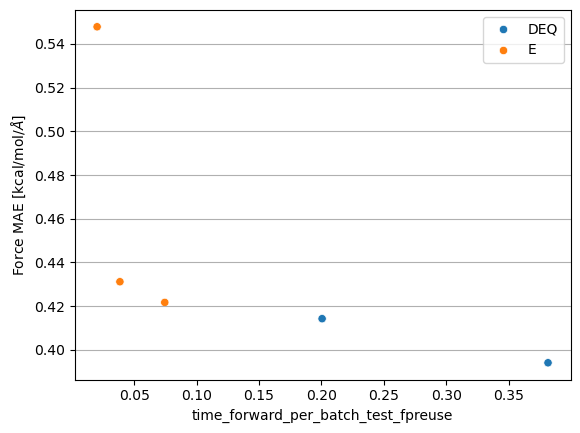

In [24]:
y = error_metric # test_fpreuse_f_mae
x = time_metric
hue = "Class"
data = df_best_runs.copy()

# only pick target aspirin
data = data[data["config.target"] == "aspirin"]

# plot
fig, ax = plt.subplots()
sns.scatterplot(
    x=x, y=y, hue=hue, data=data, ax=ax, 
    # palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title('Aspirin Error vs Time')

# vertical xtick labels
# plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

print(data[["Model", "NFE"]])

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

  Model  NFE_norm
0  DEQ1  3.384323
1  DEQ2  7.569454
2    E1  1.000000
3    E4  4.000000
4    E8  8.000000


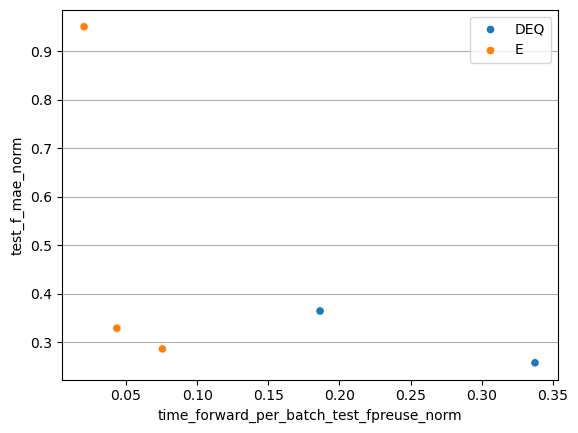

In [25]:
dfnorm, ylabel = normalize(df_best_runs.copy(), norm_scheme="minmax")
df_best_runs[f"{error_metric}_norm"] = dfnorm[error_metric]
# df_best_runs[f"{error_metric}_avg"] = df_best_runs.groupby("Model")[f"{error_metric}_norm"].mean()

df_error_avg = df_best_runs.groupby("Model")[f"{error_metric}_norm"].mean().reset_index()

for _t in tmetrics:
    dfnorm, ylabel = normalize(df_best_runs.copy(), norm_scheme="minmax")
    df_best_runs[f"{_t}_norm"] = dfnorm[_t]
    df_error_avg = df_error_avg.merge(
        df_best_runs.groupby("Model")[f"{_t}_norm"].mean().reset_index(),
        on="Model",
        how="left"
    )

# df_error_avg = df_best_runs.groupby("Model")[f"{error_metric}_norm", f"{time_metric}_norm"].mean().reset_index()
# df_error_avg = df_best_runs.groupby("Model")[f"{error_metric}_norm"].transform("mean")
# df_error_avg = df_best_runs.groupby("Model")[[f"{error_metric}_norm", f"{time_metric}_norm"]].mean()
# df_error_avg[f"time_metric"]

df_error_avg["Class"] = df_error_avg["Model"].apply(lambda x: "DEQ" if "DEQ" in x else "E")

# print(df_error_avg)
# only pick target aspirin
# data = df_best_runs.copy()
# data = data[data["config.target"] == "aspirin"]

data = df_error_avg.copy()

y = f"{error_metric}_norm" # test_fpreuse_f_mae
x = f"{time_metric}_norm"
hue = "Class"


# plot
fig, ax = plt.subplots()
sns.scatterplot(
    x=x, y=y, hue=hue, data=data, ax=ax, 
    # palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

plt.title('Normalized Error vs Time')

# vertical xtick labels
# plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

print(data[["Model", f"NFE_norm"]])

# # save
# # plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

  Model  NFE_norm
0  DEQ1  3.384323
1  DEQ2  7.569454
2    E1  1.000000
3    E4  4.000000
4    E8  8.000000


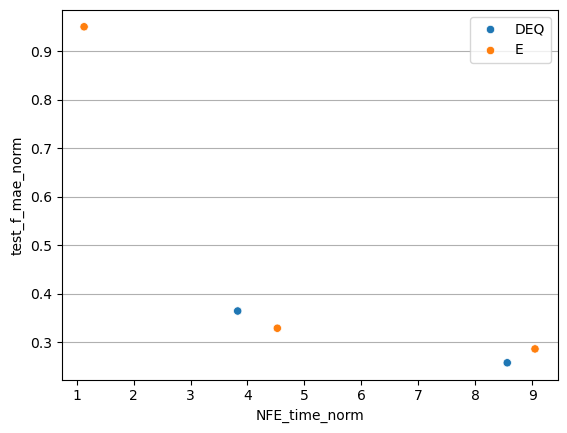

In [26]:
data = df_error_avg.copy()

y = f"{error_metric}_norm" # test_fpreuse_f_mae
x = f"NFE_time_norm"
hue = "Class"


# plot
fig, ax = plt.subplots()
sns.scatterplot(
    x=x, y=y, hue=hue, data=data, ax=ax, 
    # palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

plt.title('Normalized Error vs Time')

# vertical xtick labels
# plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

print(data[["Model", f"NFE_norm"]])

# # save
# # plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

In [27]:
# plot acc vs speed Pareto front
if project == projectmd: 
    tag = "paretomd_v1"
    fname = "mdv1"

    dfpareto = get_runs_from_wandb(
        project=project, download_data=True, 
        filters = {
            "tags": tag,
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        }, 
        fname="pareto" + fname
    )
    """
    launchrun +use=deq +cfg=ap deq_kwargs.b_stop_mode=rel deq_kwargs.f_tol=1e-4 deq_kwargs_test.f_tol=
    launchrun +use=deq +cfg=ap deq_kwargs.b_stop_mode=rel deq_kwargs.f_tol=1e-6 deq_kwargs_test.f_tol=
    """
    
    if len(dfpareto) > 0:
        dfpareto = preprocess_df(df=dfpareto, project=project, error_metric=error_metric)
        
        y = "summary.test_f_mae" # test_fpreuse_f_mae
        x = "summary.test_fpreuse_time"
        hue = "Class"
        data = dfpareto.copy()

        # plot
        fig, ax = plt.subplots()
        sns.scatterplot(
            x=x, y=y, hue=hue, data=data, ax=ax, 
            # palette=cdict
        )
        plt.legend()
        plt.xlabel(human_labels(x))
        plt.ylabel(human_labels(y))

        # vertical xtick labels
        # plt.xticks(rotation=90)

        # horizontal grid
        plt.grid(axis="y")

        # make a separate plot for each target

        # save
        # plt.savefig(f"{plotfolder}/n_steps.png")
        plt.show()

Found 0 runs:
Saved dataframe.



run_id: c66ga9sd
name: pDEQs ap bstopmode-rel loadcheckpoint-False logtracefreq-50
Processing run history (length 42824)...
len(df) notna: 4


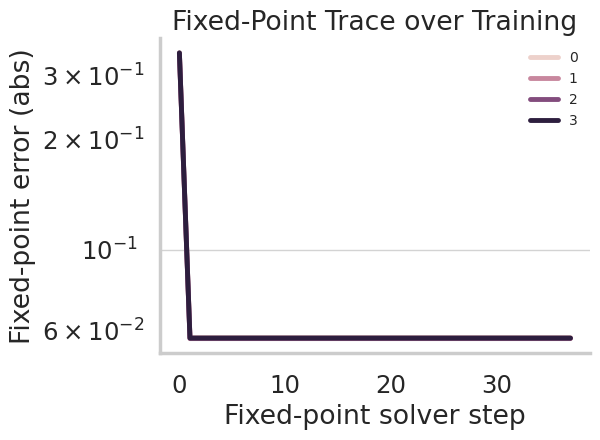

In [28]:
# plot error traj
from deq2ff.plotting.fp_error_traj_train import plot_fp_error_traj

# pDEQs ap bstopmode-rel 
# https://wandb.ai/andreas-burger/Equi2/runs/c66ga9sd
# +use=deq +cfg=ap +deq_kwargs.b_stop_mode=rel log_trace_freq=50
run_id = "c66ga9sd"
fig, ax = plot_fp_error_traj(run_id, error_type="abs", datasplit="train", logscale=True)
# plt.show()


run_id: c66ga9sd
name: pDEQs ap bstopmode-rel loadcheckpoint-False logtracefreq-50
Processing run history...
 Losses found: 38
Filtering out None values...
 Rows that were None: 0 / 857
Combining data into dataframe...


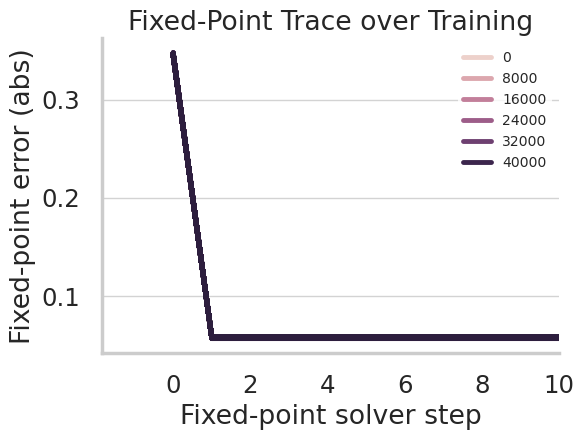

In [29]:
# plot error traj
from deq2ff.plotting.fixed_point_error_traj_list import plot_fptraj_list

# pDEQs ap bstopmode-rel 
# https://wandb.ai/andreas-burger/Equi2/runs/c66ga9sd
# +use=deq +cfg=ap +deq_kwargs.b_stop_mode=rel log_trace_freq=50
run_id = "c66ga9sd"
fig, ax = plot_fptraj_list(
    run_id, error_type="abs", datasplit="train", logscale=False, xmax=10
)
# plt.show()

In [30]:
# df_best_runs[["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]
df_best_runs[df_best_runs["config.target"] == "aspirin"][["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]

,run_name,config.target,Model,summary.train/step,config.optim.max_epochs,summary.train/epoch
35,pDEQs apf ftol-1e-3 hookift-False,aspirin,DEQ1,NaN,NaN,NaN
36,pDEQs bp numlayers-2 aspirin,aspirin,DEQ2,NaN,NaN,NaN
37,pEs dd numlayers-1 aspirin,aspirin,E1,NaN,NaN,NaN
38,pEs dd,aspirin,E4,NaN,NaN,NaN
39,pEs dd numlayers-8 aspirin,aspirin,E8,NaN,NaN,NaN


In [31]:
# ignore target==dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

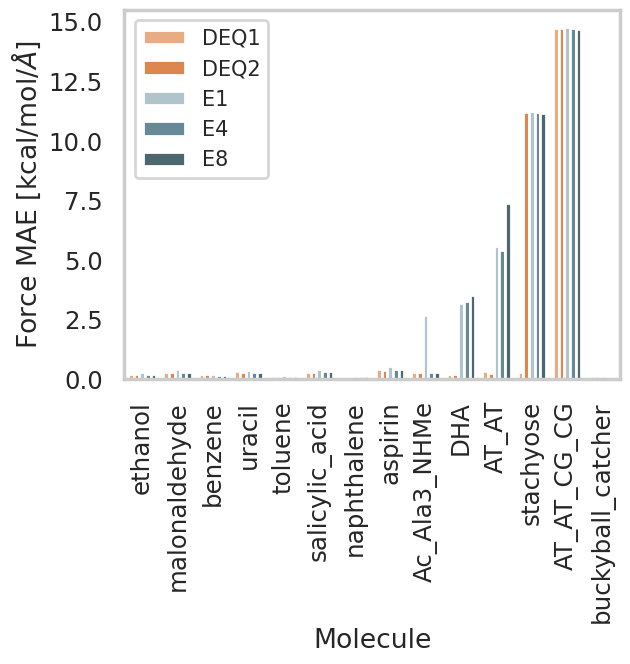

In [32]:
# plot accuracy
# grouped barchart, with target as group, and model as hue
y = error_metric
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

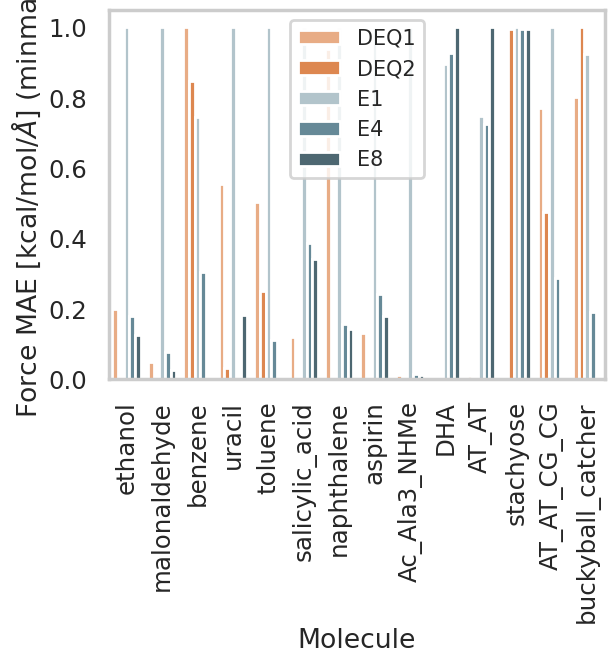

In [33]:
# plot accuracy, normalized for each target

def plot_norm_acc(_df, norm_scheme="minmax"): # norm_scheme = "zscoree4" # "mean", "minmax", "zscore", "zscoree4"

    # grouped barchart, with target as group, and model as hue
    y = error_metric
    x = "config.target"
    hue = "Model"
    data = _df.copy()

    data, ylabel = normalize(data, norm_scheme=norm_scheme)

    # plot
    fig, ax = plt.subplots()
    sns.barplot(
        x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict
    )
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(ylabel)

    # where "sota" is True, mark the run with a green star
    # for target in data["config.target"].unique():
    #     _df = data[data["config.target"] == target]
    #     _df = _df[_df["sota"] == True]
    #     for index in _df.index:
    #         ax.plot(index, _df.loc[index, y], "o", color="green", markersize=10)

    # vertical xtick labels
    plt.xticks(rotation=90)

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/n_steps.png")
    plt.show()

plot_norm_acc(df_best_runs, norm_scheme="minmax")

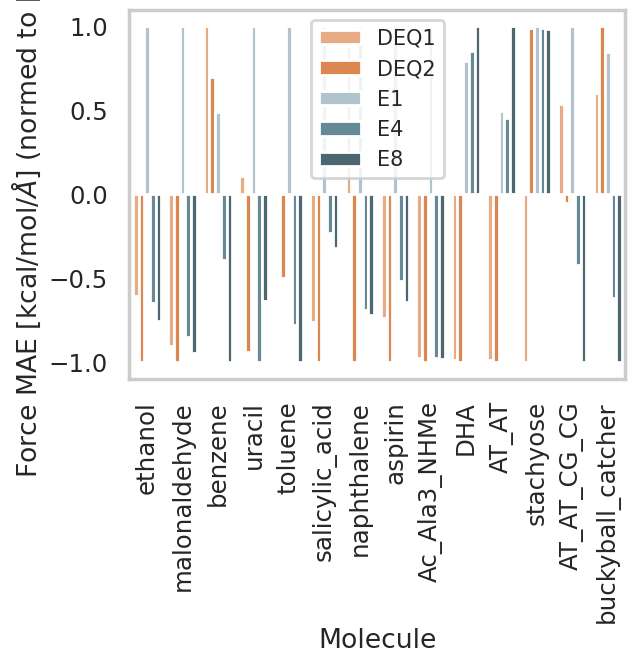

In [34]:
plot_norm_acc(df_best_runs, norm_scheme="minmax2")


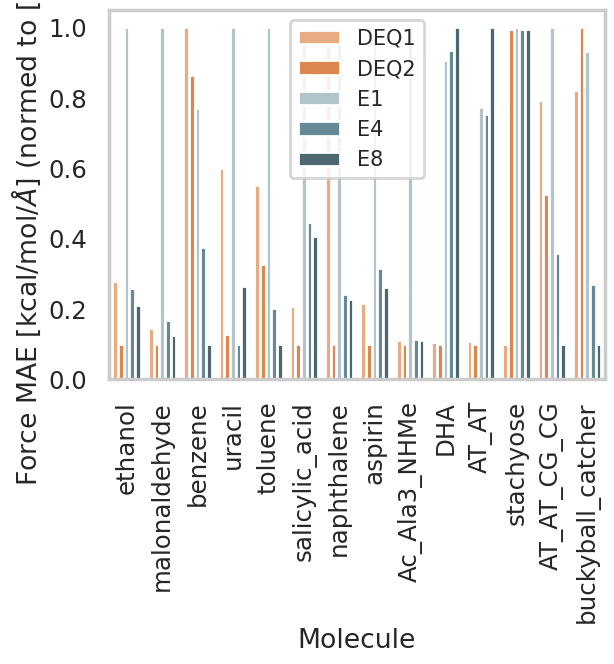

In [35]:
plot_norm_acc(df_best_runs, norm_scheme="minmax3")


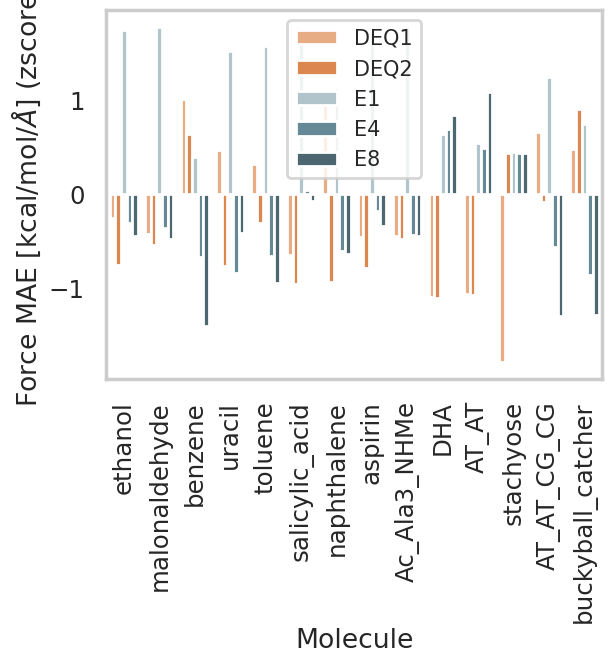

In [36]:
plot_norm_acc(df_best_runs, norm_scheme="zscore")

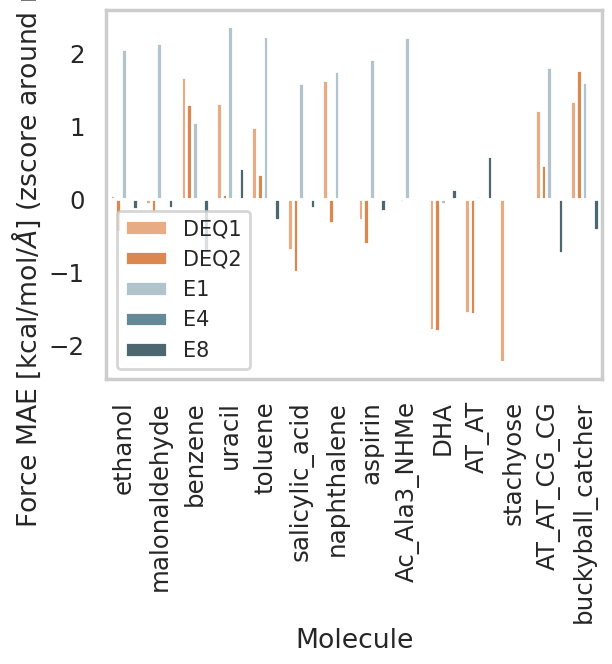

In [37]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")

In [38]:
df_best_runs[df_best_runs["Model"] == "E4"][["run_name", "config.target"]]

,run_name,config.target
3,pEs dd ethanol,ethanol
8,pEs dd malonaldehyde,malonaldehyde
13,pEs dd benzene,benzene
18,pEs dd uracil,uracil
23,pEs dd toluene,toluene
28,pEs dd salicylicacid,salicylic_acid
33,pEs dd naphthalene,naphthalene
38,pEs dd,aspirin
43,pEs dd md22 AcAla3NHMe,Ac_Ala3_NHMe
48,pEs dd md22 DHA,DHA


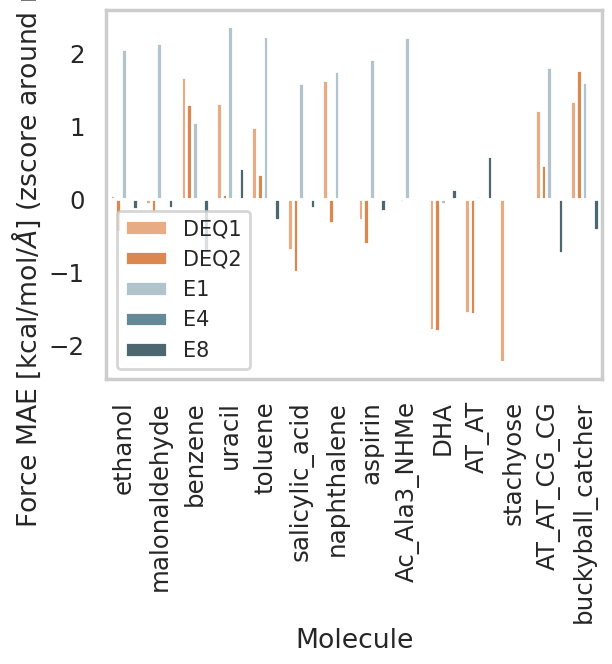

In [39]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")


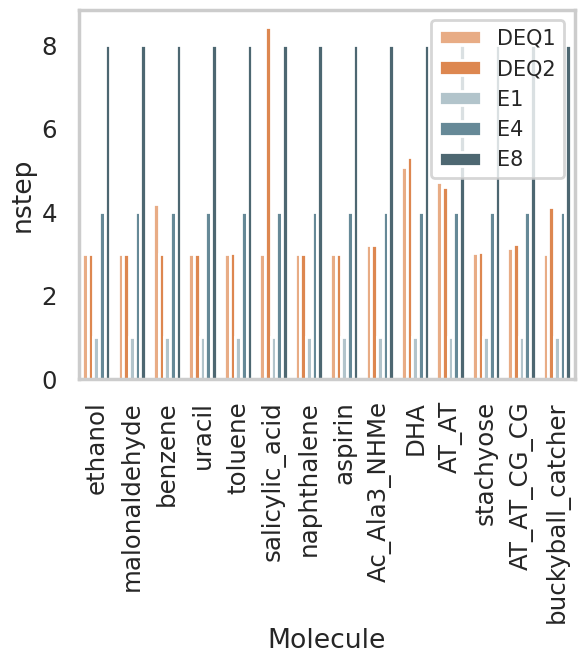

In [40]:
# plot n_step
# grouped barchart, with target as group, and model as hue

y = "nstep"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

# print names of plotted runs
# data["run_name"]

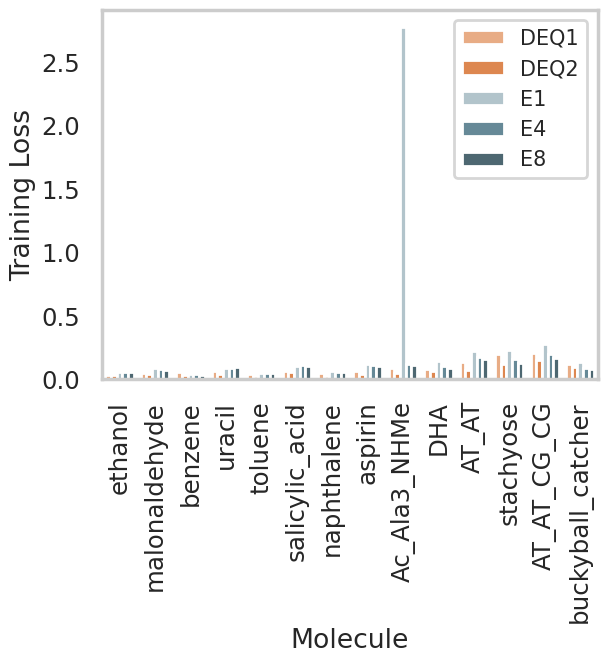

In [41]:
# plot train_loss_f

# grouped barchart, with target as group, and model as hue
if project == projectmd:
    y = "summary.train_loss_f"
elif project == projectoc:
    y = "summary.train/forces_mae"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

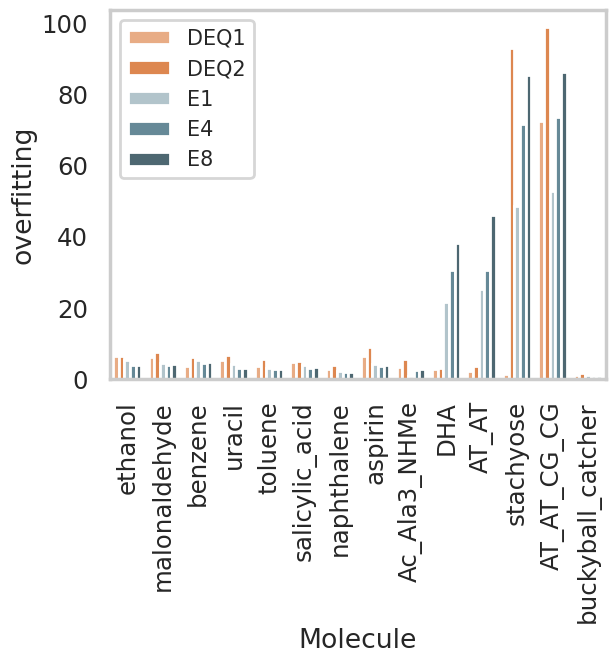

In [42]:
# overfitting = test_loss / train_loss
if project == projectmd:
    df_best_runs["overfitting"] = df_best_runs["summary.test_f_mae"] / df_best_runs["summary.train_loss_f"]
elif project == projectoc:
    df_best_runs["overfitting"] = df_best_runs["summary.val/forces_mae"] / df_best_runs["summary.train/forces_mae"]

y = "overfitting"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

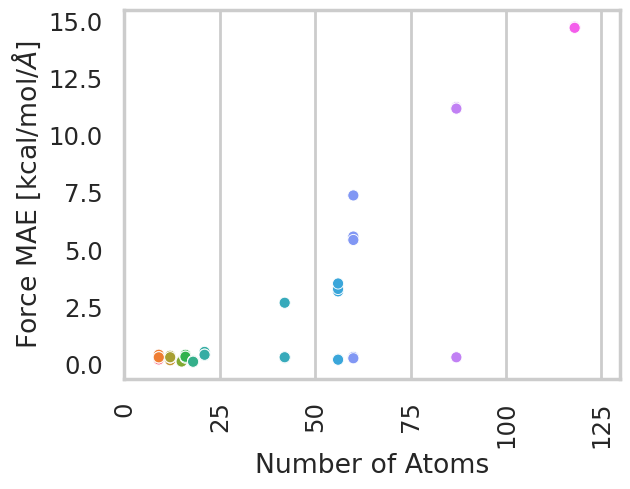

In [43]:
# plot test loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot 
    x = "num_atoms"
    # y = "summary.test_loss_f" # TODO: no longer logged?
    y = "summary.test_f_mae" # TODO: no longer logged?
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))

    # vertical xtick labels
    plt.xticks(rotation=90)

    ax.set_xlim(0, 130)
    
    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

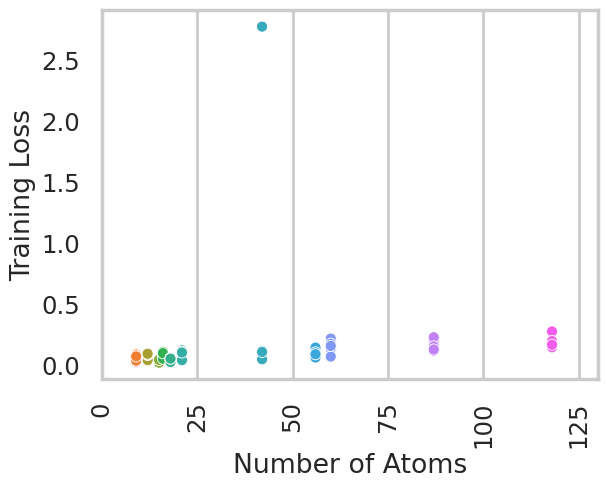

In [44]:
# plot train loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot 
    x = "num_atoms"
    y = "summary.train_loss_f"
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))

    # vertical xtick labels
    plt.xticks(rotation=90)

    # legend off
    ax.set_xlim(0, 130)
    
    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

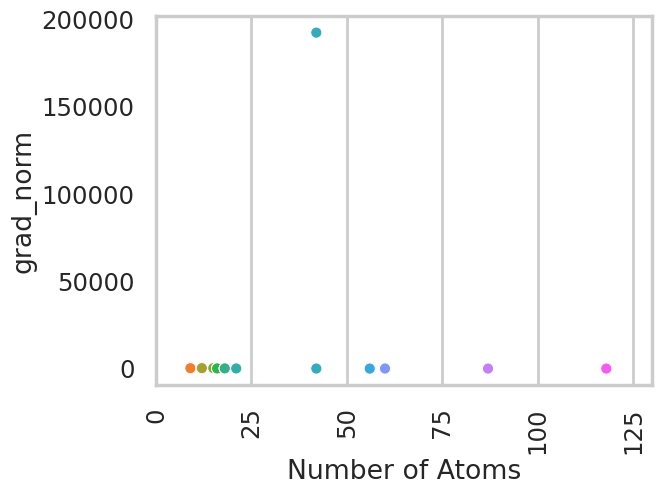

In [45]:
# plot gradient norm per molecule

fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot 
x = "num_atoms"
y = "summary.grad_norm"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

ax.set_xlim(0, 130)
    
ax.get_legend().remove()

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

In [46]:
data["config.deq_kwargs.n_states"]

0     3.0
1     1.0
2     0.0
3     0.0
4     0.0
     ... 
65    1.0
66    3.0
67    0.0
68    0.0
69    0.0
Name: config.deq_kwargs.n_states, Length: 70, dtype: float64

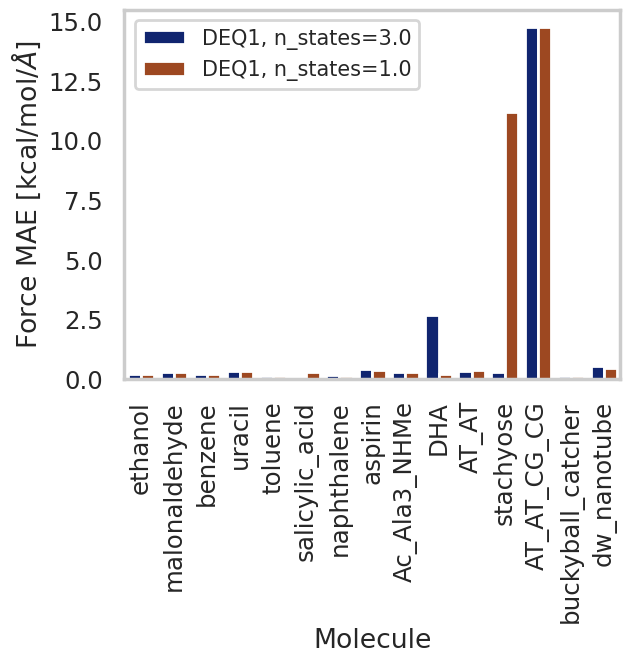

In [47]:
# compare n_states=3 to no fpc

df_nstates = []

for target in df["config.target"].unique():
    criteriatarget = {"config.target": target}

    # best DEQ
    criteria_deq = {
        "config.model_is_deq": True, "config.model.num_layers": 1, 
        "config.deq_kwargs.n_states": 3, "config.deq_kwargs.f_tol": 1e-2,
        # "config.model.enc_ln": False # model.enc_ln=True
        "config.model.attn_alpha_channels": 16,
    }
    anti_criteria = {"config.dname": "ccsd"}
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df, df_out=df_nstates, metric=error_metric, 
        criteria=criteria_deq, anti_criteria=anti_criteria
    )

    criteria_deq["config.deq_kwargs.n_states"] = 1.0
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df, df_out=df_nstates, metric=error_metric, 
        criteria=criteria_deq, anti_criteria=anti_criteria
        )

df_nstates = pd.concat(df_nstates)

# add n_states to "model" column
df_nstates["Model"] = df_nstates["Model"] + df_nstates["config.deq_kwargs.n_states"].apply(
    lambda x: f", n_states={x}" if x is not None else ""
)

# grouped barchart, with target as group, and model as hue
y = "summary.test_f_mae"
x = "config.target"
hue = "Model"
data = df_nstates.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()

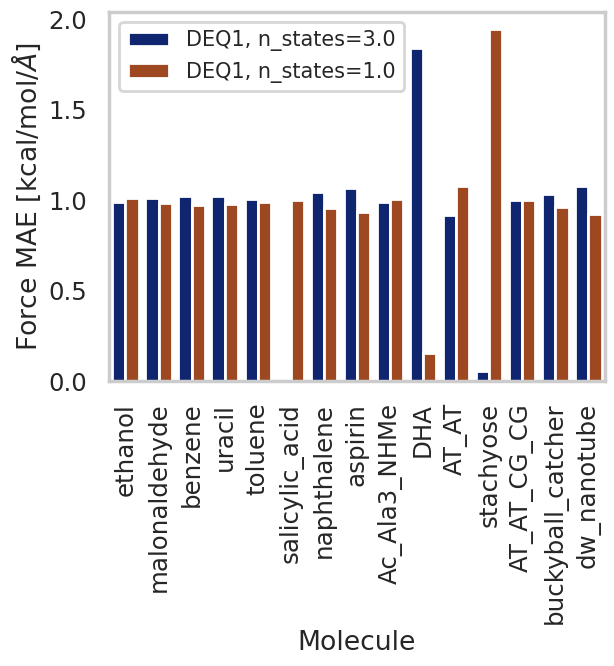

In [48]:
# compare n_states=3 to no fpc

# norm data[y] for each target
# data[y] = data.groupby(x)[y].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data[y] = data.groupby(x)[y].transform(lambda x: x / x.mean())

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()